In [1]:
import numpy as np
import pandas as pd
import random
import os
from os.path import join
import datetime
import time
import sys

sys.path.append("../")

import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import utilities
import aggregate

# Data preparations

In [124]:
# prepare timeline
dict_crypto_name, data = aggregate.aggregate("../../../history", "06.06.2017", "01.02.2018",["O","C","H","L"])
data = data.T.values
data_interpolated = utilities.interpolate_data(data)
N, T = data_interpolated.shape

Ignored currencies with not enough data for given date range: 56


In [3]:
# save data
np.savetxt('merged_transposed_series.csv', data, delimiter=';')

In [4]:
import pylab as pl

def draw_plot(true_data, index_to_check, pred_data = []):

    pl.figure(figsize=(30,5))
    if len(pred_data) > 0:
        x_axis = np.arange(len(true_data)-len(pred_data),len(true_data))
        plt.plot(x_axis, pred_data, color='red')
    pl.plot(true_data, color='blue')
    pl.title("%s"%dict_crypto_name[index_to_check])

    pl.show()

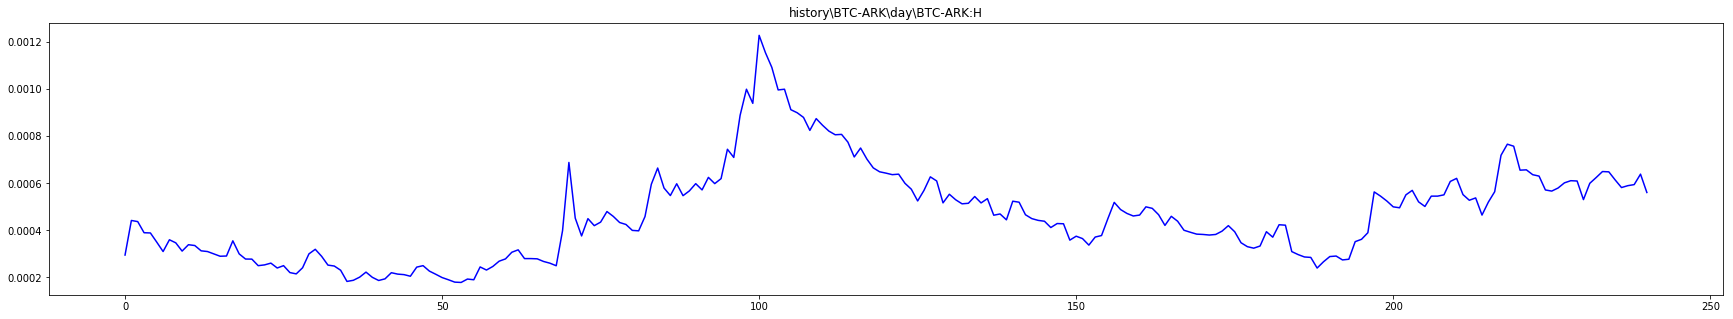

In [125]:
draw_plot(data_interpolated[34],34)

In [6]:
def draw_test_plot(model, index_to_check):

    model.fit(data_interpolated[:,:-20])
    pred_vals = model.predict(20)

    draw_plot(data_interpolated[index_to_check], index_to_check, pred_data=pred_vals[index_to_check])

# Autoregressive models for each of feature of our dataset.
The most good lags parameter was 1 for such kind of the model, but it works mostly for prediction nearest values (h = 1,5,10), but if we want farther predictions, this model doesn't fit.

In [20]:
from models import IndependentFeaturesAutoRegressionModel

In [126]:
errors_ind_ar = []
for lags in [[1],[1,7],[1,7,14],[1, 7, 14, 30],[1,2,3,4,5,6,7,14,21]]:
    temp = []
    for h in [1, 5, 10, 20]:
        model = IndependentFeaturesAutoRegressionModel(lags)
        scores_nd = utilities.RollingCV(model, data_interpolated, T-h, h, T_step=1, metric='ND')
        scores_nrmse = utilities.RollingCV(model, data_interpolated, T-h, h, T_step=1, metric='NRMSE')
        print('Independent AR performance ND/NRMSE (h = {}, lags = {}): {}/{}'.format(h,lags, round(np.array(scores_nd).mean(),3),\
                                                                   round(np.array(scores_nrmse).mean(),3))) 
        temp.append((round(np.array(scores_nd).mean(),3), round(np.array(scores_nrmse).mean(),3)))
    errors_ind_ar.append(temp)

Independent AR performance ND/NRMSE (h = 1, lags = [1]): 0.203/0.295
Independent AR performance ND/NRMSE (h = 5, lags = [1]): 0.276/0.42
Independent AR performance ND/NRMSE (h = 10, lags = [1]): 0.345/0.552
Independent AR performance ND/NRMSE (h = 20, lags = [1]): 0.51/0.809
Independent AR performance ND/NRMSE (h = 1, lags = [1, 7]): 0.212/0.312
Independent AR performance ND/NRMSE (h = 5, lags = [1, 7]): 0.267/0.398
Independent AR performance ND/NRMSE (h = 10, lags = [1, 7]): 0.339/0.541
Independent AR performance ND/NRMSE (h = 20, lags = [1, 7]): 0.601/1.364
Independent AR performance ND/NRMSE (h = 1, lags = [1, 7, 14]): 0.215/0.318
Independent AR performance ND/NRMSE (h = 5, lags = [1, 7, 14]): 0.289/0.431
Independent AR performance ND/NRMSE (h = 10, lags = [1, 7, 14]): 0.398/0.692
Independent AR performance ND/NRMSE (h = 20, lags = [1, 7, 14]): 0.652/1.446
Independent AR performance ND/NRMSE (h = 1, lags = [1, 7, 14, 30]): 0.263/0.396
Independent AR performance ND/NRMSE (h = 5, lags

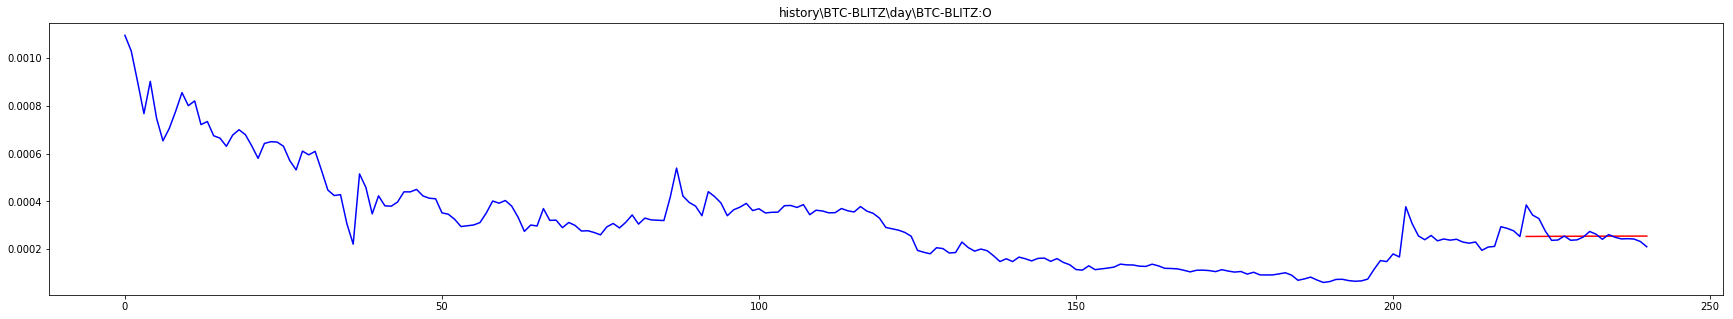

In [127]:
draw_test_plot(IndependentFeaturesAutoRegressionModel([1]), 56)

# Autoregressive model for all taken features together
The result showed that with increasing lags number we have better accuracy. 

In [24]:
from models import AutoRegressionModel
from statsmodels.tsa.vector_ar.var_model import VAR

In [128]:
errors_ar = []
for lags in [[1],[1,7],[1,7,14],[1,7,14,30],[1,2,3,4,5,6,7,14,21]]:
    temp = []
    for h in [1, 5, 10, 20]:
        model = AutoRegressionModel(lags)
        scores_nd = utilities.RollingCV(model, data_interpolated, T-h, h, T_step=1, metric='ND')
        scores_nrmse = utilities.RollingCV(model, data_interpolated, T-h, h, T_step=1, metric='NRMSE')
        print('AR performance ND/NRMSE (h = {}, lags = {}): {}/{}'.format(h,lags, round(np.array(scores_nd).mean(),3),\
                                                               round(np.array(scores_nrmse).mean(),3))) 
        temp.append((round(np.array(scores_nd).mean(),3), round(np.array(scores_nrmse).mean(),3)))
    errors_ar.append(temp)

C:\Users\Asus\Anaconda3_new\lib\site-packages\statsmodels\tsa\vector_ar\var_model.py:461: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  params = np.linalg.lstsq(z, y_sample)[0]


AR performance ND/NRMSE (h = 1, lags = [1]): 2.479/3.134
AR performance ND/NRMSE (h = 5, lags = [1]): 2.214/2.656
AR performance ND/NRMSE (h = 10, lags = [1]): 2.109/2.513
AR performance ND/NRMSE (h = 20, lags = [1]): 1.845/2.203
AR performance ND/NRMSE (h = 1, lags = [1, 7]): 0.244/0.331
AR performance ND/NRMSE (h = 5, lags = [1, 7]): 0.389/0.517
AR performance ND/NRMSE (h = 10, lags = [1, 7]): 0.68/0.932
AR performance ND/NRMSE (h = 20, lags = [1, 7]): 1.868/2.353
AR performance ND/NRMSE (h = 1, lags = [1, 7, 14]): 0.25/0.34
AR performance ND/NRMSE (h = 5, lags = [1, 7, 14]): 0.399/0.52
AR performance ND/NRMSE (h = 10, lags = [1, 7, 14]): 0.656/0.887
AR performance ND/NRMSE (h = 20, lags = [1, 7, 14]): 1.612/2.079
AR performance ND/NRMSE (h = 1, lags = [1, 7, 14, 30]): 0.277/0.366
AR performance ND/NRMSE (h = 5, lags = [1, 7, 14, 30]): 0.464/0.586
AR performance ND/NRMSE (h = 10, lags = [1, 7, 14, 30]): 0.68/0.892
AR performance ND/NRMSE (h = 20, lags = [1, 7, 14, 30]): 1.221/1.531
A

C:\Users\Asus\Anaconda3_new\lib\site-packages\statsmodels\tsa\vector_ar\var_model.py:461: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  params = np.linalg.lstsq(z, y_sample)[0]


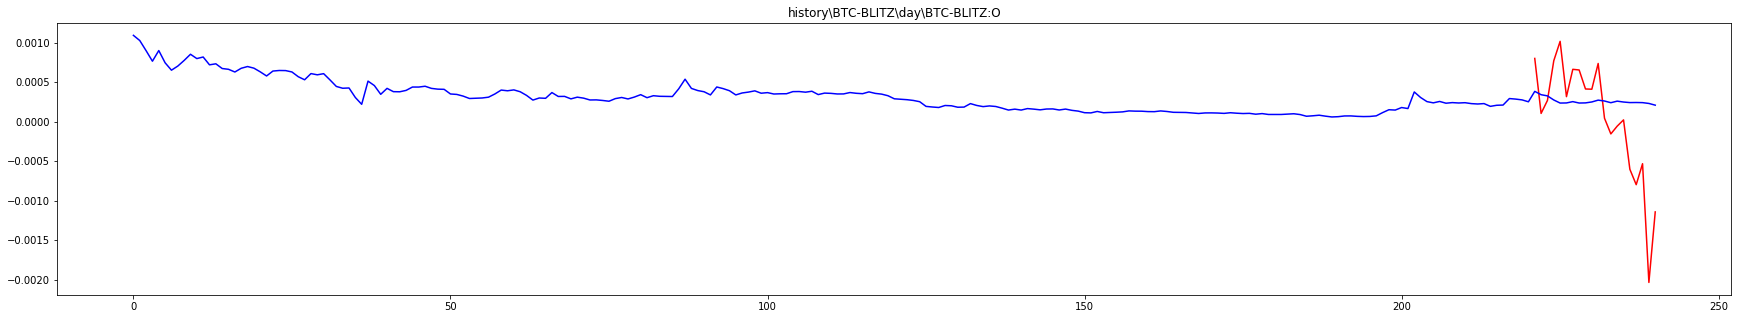

In [129]:
draw_test_plot(AutoRegressionModel([1, 7, 14, 30]), 56)

# Autoregression model with prior SVD dimension reduction for all features together
The results showed worse accuracy that just Autoregressive model, but with increasing number of lags considered accuracy is improving.

In [130]:
from models import SvdAutoRegressionModel
errors_svd_ar = []
for lags in [[1],[1,7],[1,7,14],[1,7,14,30],[1,2,3,4,5,6,7,14,21]]:
    temp = []
    for h in [1, 5, 10, 20]:
        model = SvdAutoRegressionModel(lags)
        scores_nd = utilities.RollingCV(model, data_interpolated, T-h, h, T_step=1, metric='ND')
        scores_nrmse = utilities.RollingCV(model, data_interpolated, T-h, h, T_step=1, metric='NRMSE')
        print('SVD AR performance ND/NRMSE (h = {}, lags = {}): {}/{}'.format(h, lags, round(np.array(scores_nd).mean(),3),\
                                                               round(np.array(scores_nrmse).mean(),3))) 
        temp.append((round(np.array(scores_nd).mean(),3), round(np.array(scores_nrmse).mean(),3)))
    errors_svd_ar.append(temp)

C:\Users\Asus\Anaconda3_new\lib\site-packages\statsmodels\tsa\vector_ar\var_model.py:461: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  params = np.linalg.lstsq(z, y_sample)[0]


SVD AR performance ND/NRMSE (h = 1, lags = [1]): 6.804/7.606
SVD AR performance ND/NRMSE (h = 5, lags = [1]): 4.218/5.091
SVD AR performance ND/NRMSE (h = 10, lags = [1]): 2.84/3.654
SVD AR performance ND/NRMSE (h = 20, lags = [1]): 2.984/3.742
SVD AR performance ND/NRMSE (h = 1, lags = [1, 7]): 1.349/1.596
SVD AR performance ND/NRMSE (h = 5, lags = [1, 7]): 1.27/1.526
SVD AR performance ND/NRMSE (h = 10, lags = [1, 7]): 1.244/1.508
SVD AR performance ND/NRMSE (h = 20, lags = [1, 7]): 1.092/1.412
SVD AR performance ND/NRMSE (h = 1, lags = [1, 7, 14]): 1.014/1.292
SVD AR performance ND/NRMSE (h = 5, lags = [1, 7, 14]): 1.03/1.309
SVD AR performance ND/NRMSE (h = 10, lags = [1, 7, 14]): 1.097/1.378
SVD AR performance ND/NRMSE (h = 20, lags = [1, 7, 14]): 1.048/1.417
SVD AR performance ND/NRMSE (h = 1, lags = [1, 7, 14, 30]): 0.981/1.292
SVD AR performance ND/NRMSE (h = 5, lags = [1, 7, 14, 30]): 0.992/1.306
SVD AR performance ND/NRMSE (h = 10, lags = [1, 7, 14, 30]): 1.022/1.338
SVD AR p

C:\Users\Asus\Anaconda3_new\lib\site-packages\statsmodels\tsa\vector_ar\var_model.py:461: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  params = np.linalg.lstsq(z, y_sample)[0]


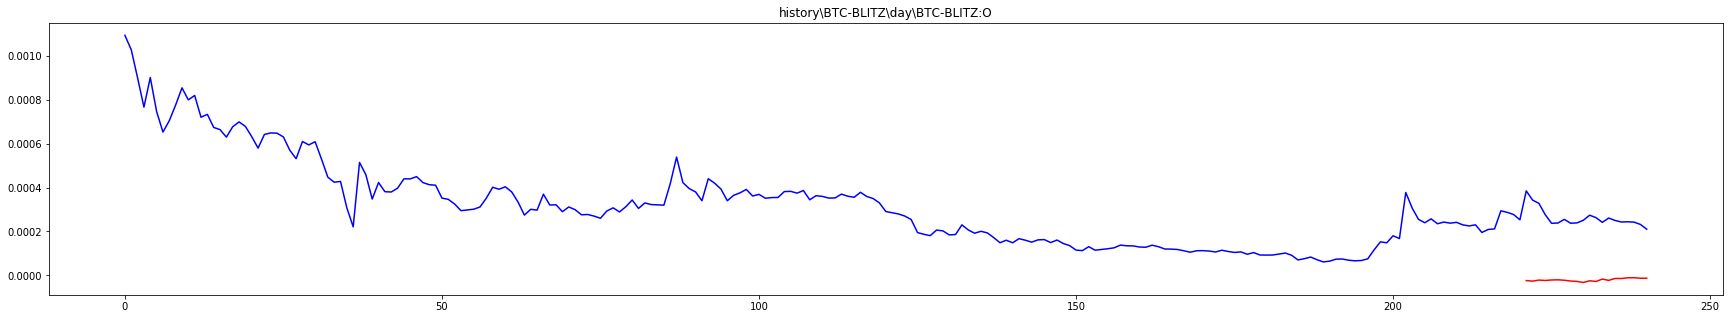

In [131]:
draw_test_plot(SvdAutoRegressionModel([1,7,14]), 56)

# Simple TRMF model

The results so far worse than Autoregressive model because of algorithm's simpleness and small number of iterations.

In [132]:
from trmf_naive import TRMFNaive

lags = [1,2,3,4,5,6,7,14,21]
rank = 256
lambda_f = 0.001
lambda_x = 0.01
lambda_w = 0.0001
alpha = 1000.
eta = 0.
num_iter = 200

In [133]:
for h in [1, 5, 10, 20]:
    model = TRMFNaive(lags, rank, lambda_f, lambda_x, lambda_w, alpha, eta, num_iter)
    scores_nd = utilities.RollingCV(model, data, T - h, h, T_step=1, metric='ND')
    scores_nrmse = utilities.RollingCV(model, data, T - h, h, T_step=1, metric='NRMSE')
    print('TRMFNaive performance ND/NRMSE (h = {}): {}/{}'.format(h, round(np.array(scores_nd).mean(), 3), \
                                                             round(np.array(scores_nrmse).mean(), 3)))

TRMFNaive performance ND/NRMSE (h = 1): 1.368/1.662
TRMFNaive performance ND/NRMSE (h = 5): 1.068/1.352
TRMFNaive performance ND/NRMSE (h = 10): 1.015/1.237
TRMFNaive performance ND/NRMSE (h = 20): 0.936/1.1


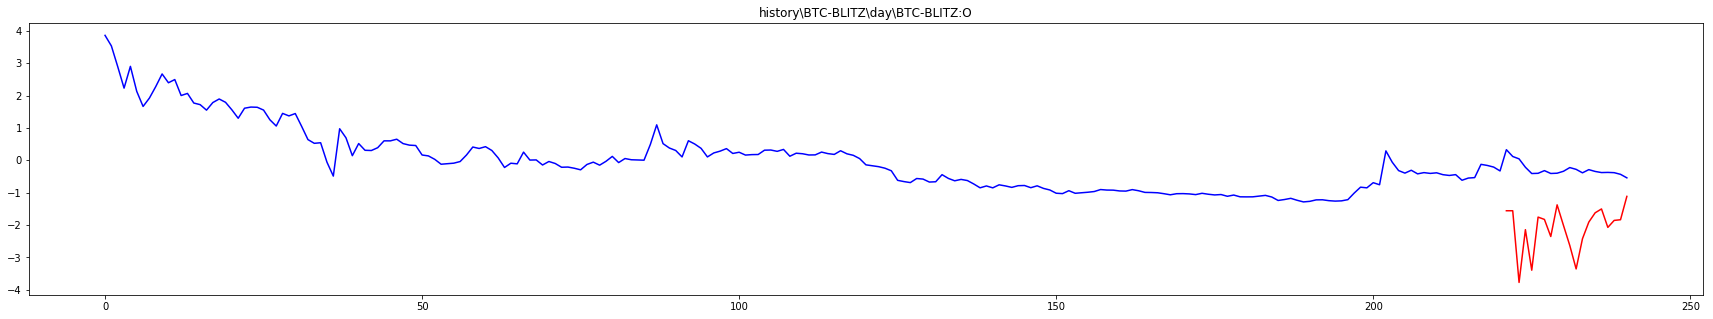

In [134]:
horizon = 20
check_idx = 56
model = TRMFNaive(lags, rank, lambda_f, lambda_x, lambda_w, alpha, eta, 2000)
train, test = get_slice(data, T - horizon, horizon, 0)
model.fit(train)
predicted_data = model.predict(horizon)
draw_plot(np.concatenate((train[check_idx],test[check_idx]),axis=0), check_idx, predicted_data[check_idx])

# TRMF model

In [6]:
from models import TRMF

In [8]:
T = data.shape[1]
errors_ind_ar = []
for lags in [[1],[1,7],[1,7,14],[1,7,14,30],[1,2,3,4,5,6,7,14,21]]:
    temp = []
    for h in [1, 5, 10, 20]:
        model = TRMF(lags=lags)
        scores_nd = utilities.RollingCV(model, data, T - h, h, T_step=1, metric='ND', normalize=False)
        scores_nrmse = utilities.RollingCV(model, data, T - h, h, T_step=1, metric='NRMSE', normalize=False)
        print('TRMF performance ND/NRMSE (h = {}, lags = {}): {}/{}'
              .format(h, lags, round(np.array(scores_nd).mean(), 3), round(np.array(scores_nrmse).mean(), 3)))
        temp.append((round(np.array(scores_nd).mean(), 3), round(np.array(scores_nrmse).mean(), 3)))
    errors_ind_ar.append(temp)

TRMF performance ND/NRMSE (h = 1, lags = [1]): 0.073/0.938
TRMF performance ND/NRMSE (h = 5, lags = [1]): 0.106/1.251
TRMF performance ND/NRMSE (h = 10, lags = [1]): 0.068/0.878
TRMF performance ND/NRMSE (h = 20, lags = [1]): 0.124/1.611
TRMF performance ND/NRMSE (h = 1, lags = [1, 7]): 0.073/0.938
TRMF performance ND/NRMSE (h = 5, lags = [1, 7]): 0.106/1.251
TRMF performance ND/NRMSE (h = 10, lags = [1, 7]): 0.068/0.878
TRMF performance ND/NRMSE (h = 20, lags = [1, 7]): 0.124/1.611
TRMF performance ND/NRMSE (h = 1, lags = [1, 7, 14]): 0.073/0.938
TRMF performance ND/NRMSE (h = 5, lags = [1, 7, 14]): 0.106/1.251
TRMF performance ND/NRMSE (h = 10, lags = [1, 7, 14]): 0.068/0.878
TRMF performance ND/NRMSE (h = 20, lags = [1, 7, 14]): 0.124/1.611
TRMF performance ND/NRMSE (h = 1, lags = [1, 7, 14, 30]): 0.066/0.897
TRMF performance ND/NRMSE (h = 5, lags = [1, 7, 14, 30]): 0.095/1.125
TRMF performance ND/NRMSE (h = 10, lags = [1, 7, 14, 30]): 0.055/0.719
TRMF performance ND/NRMSE (h = 20, 

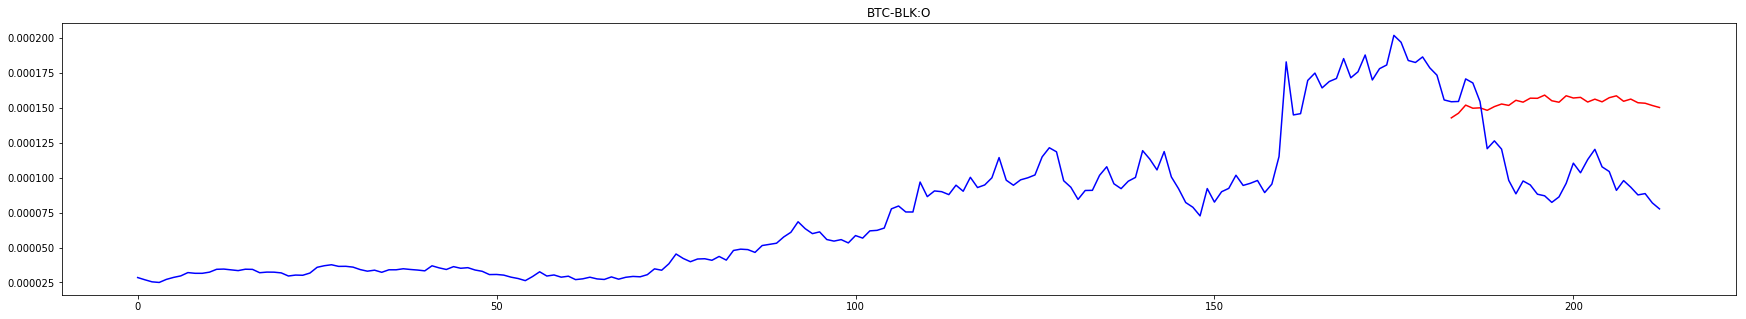

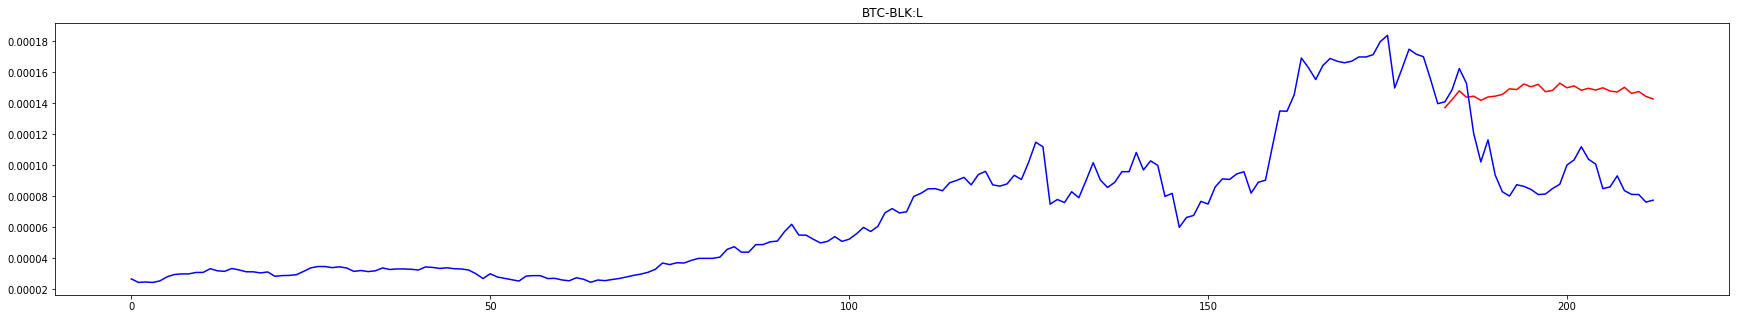

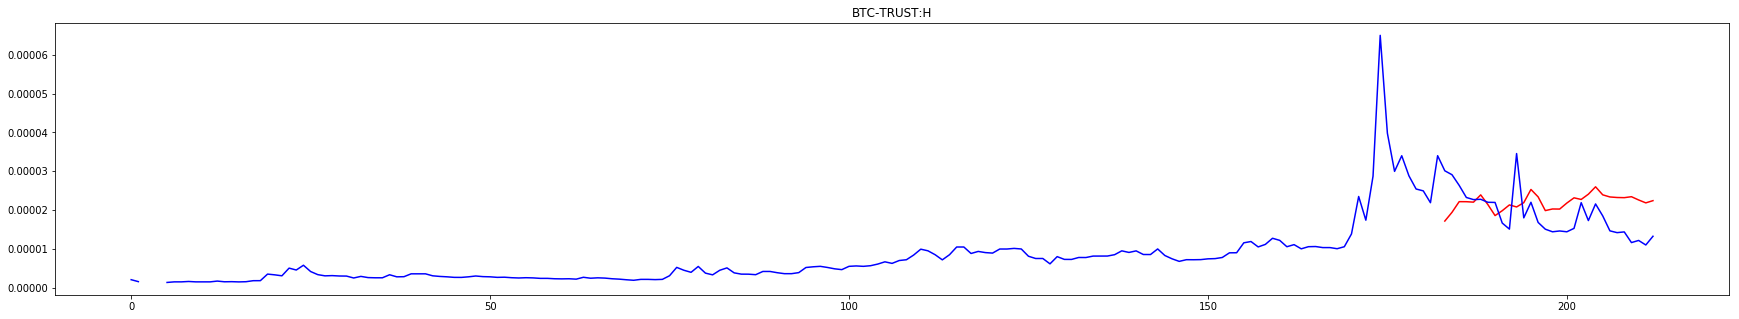

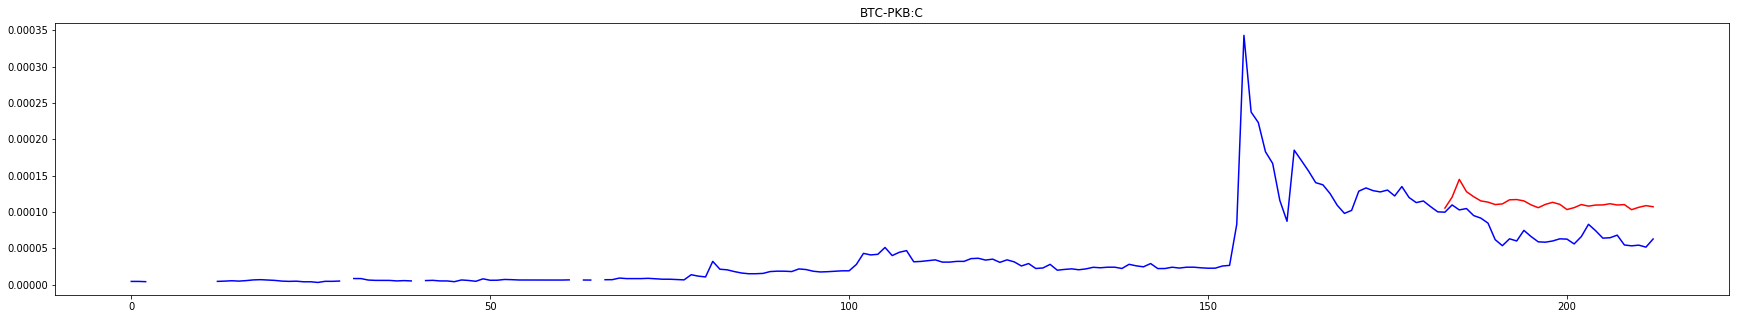

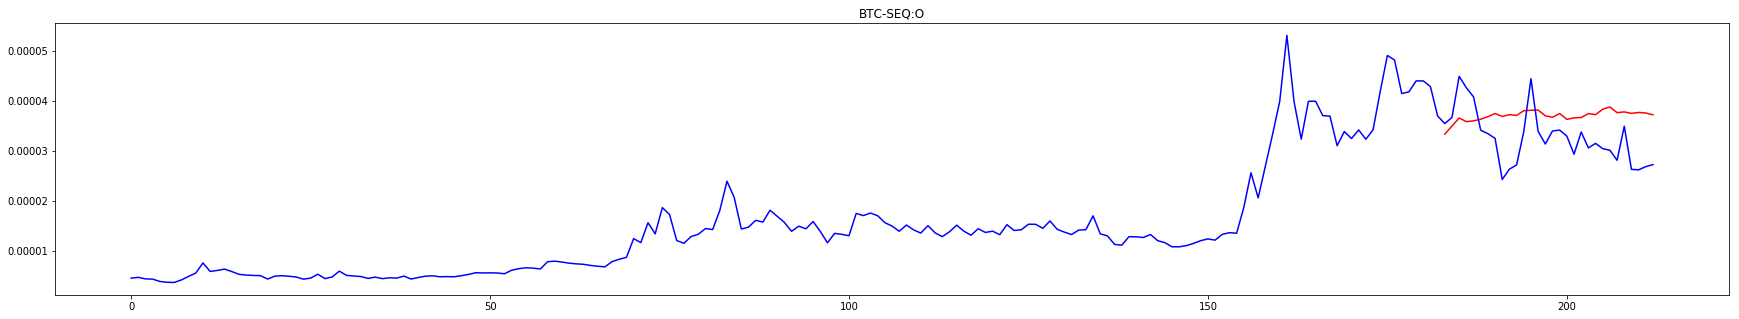

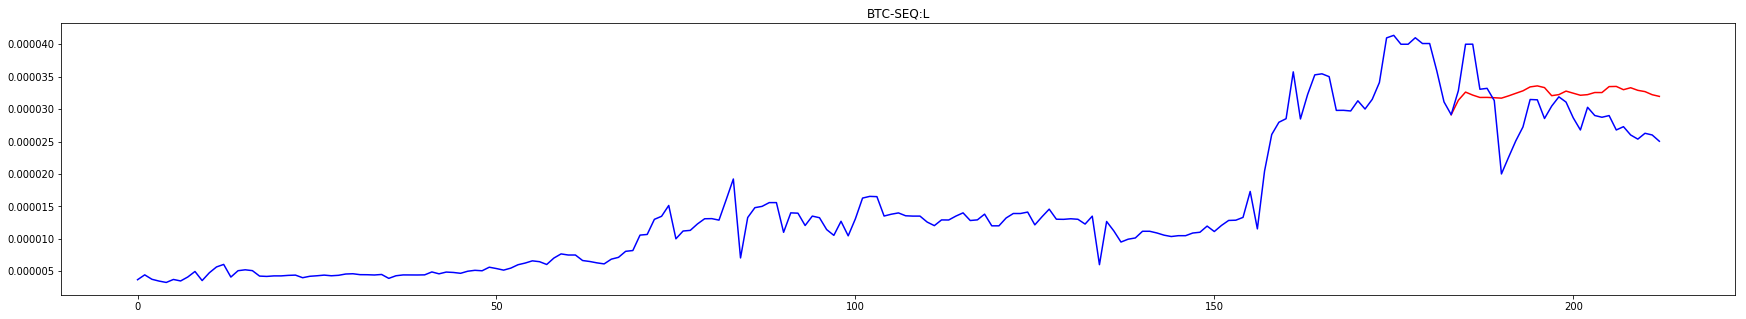

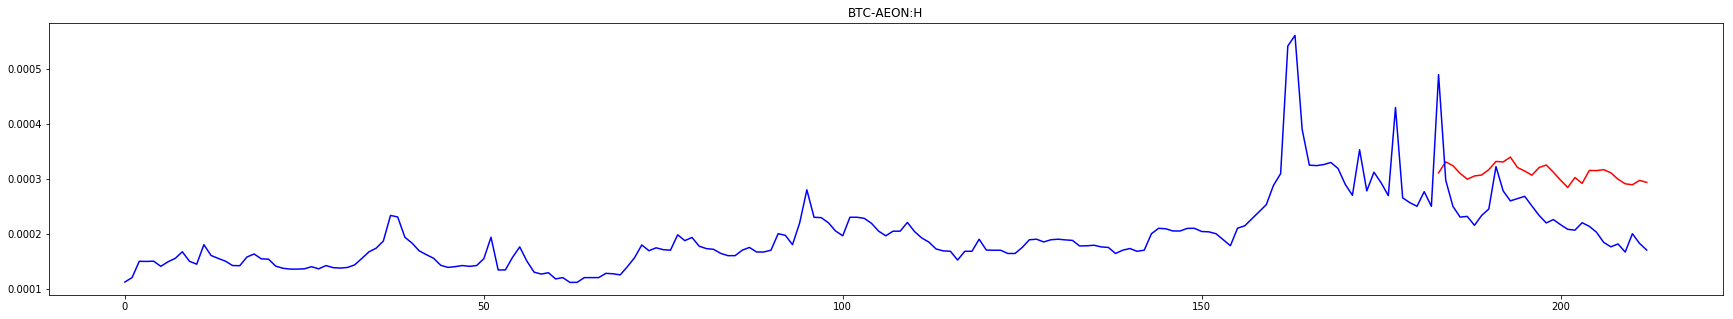

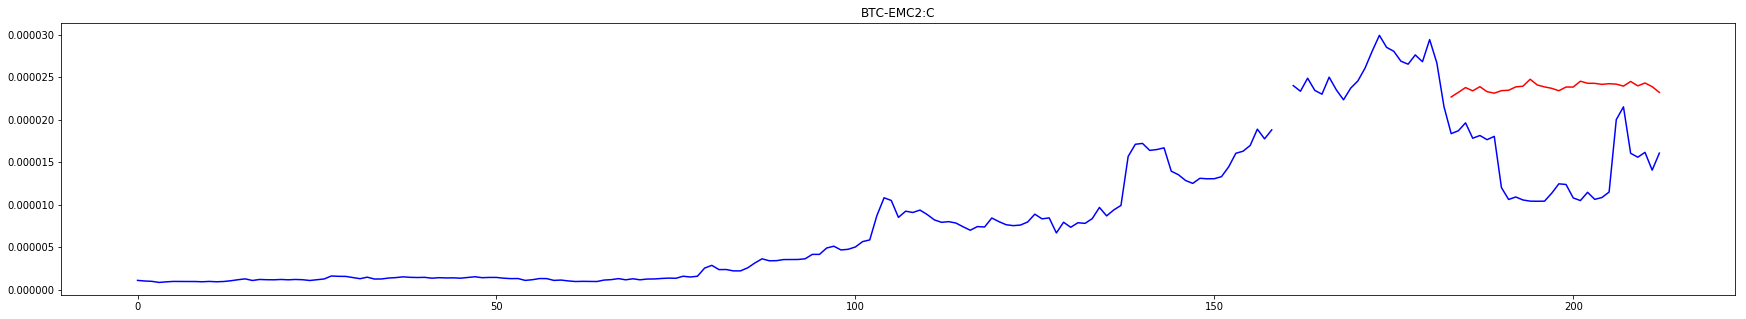

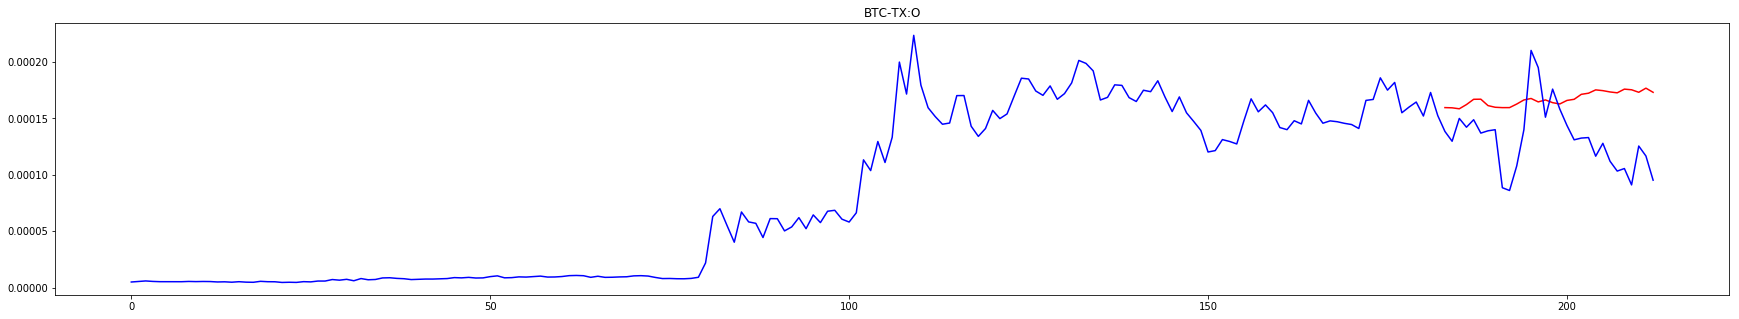

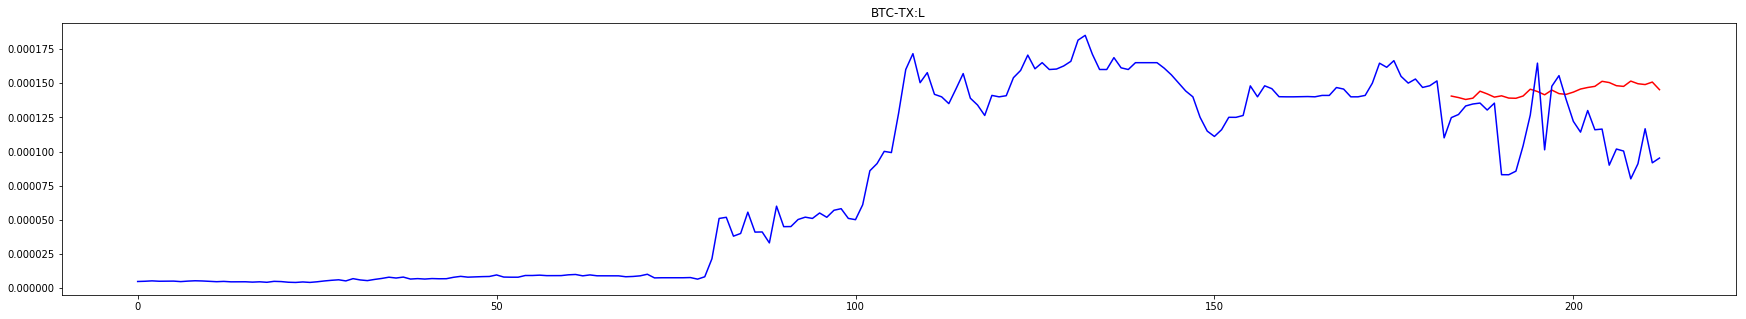

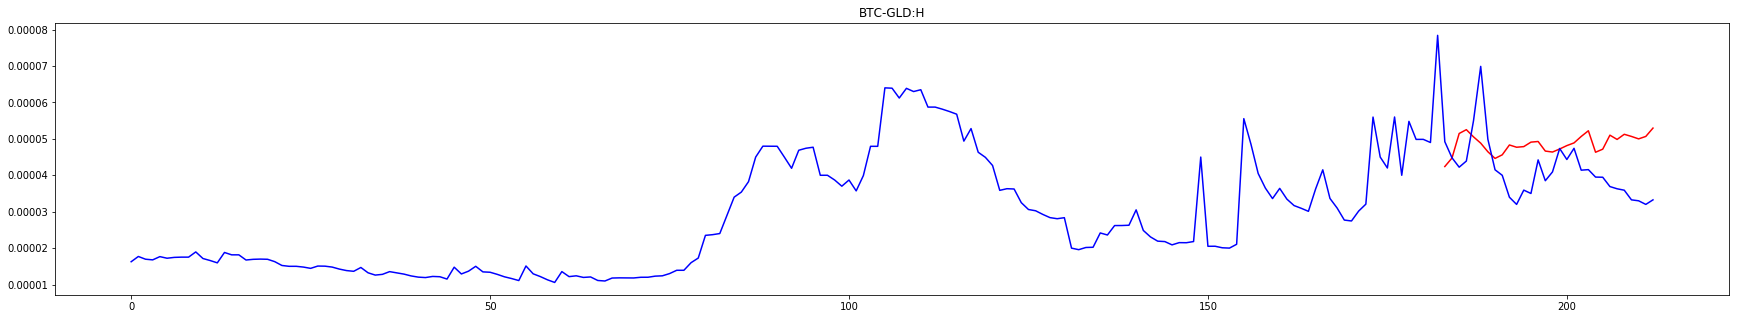

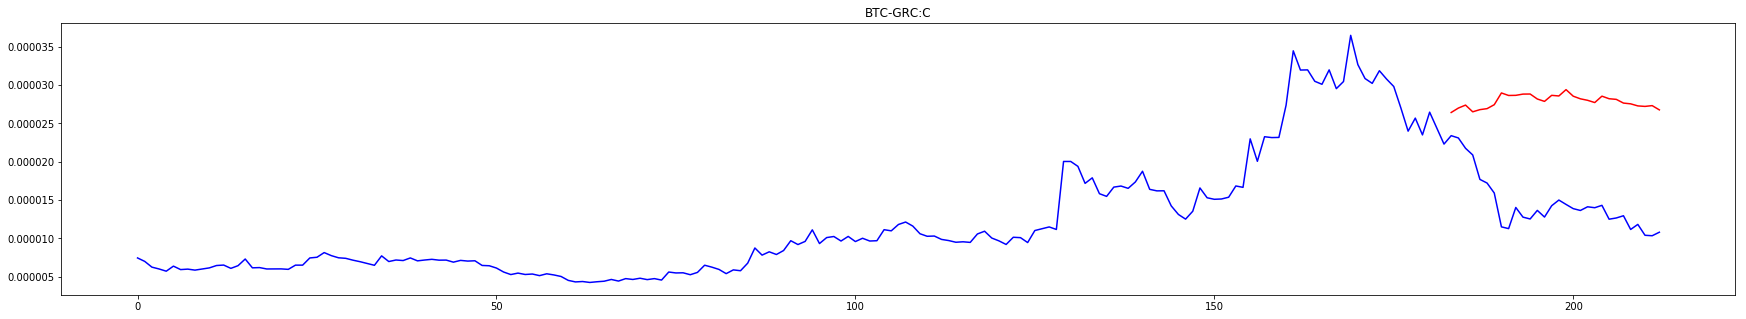

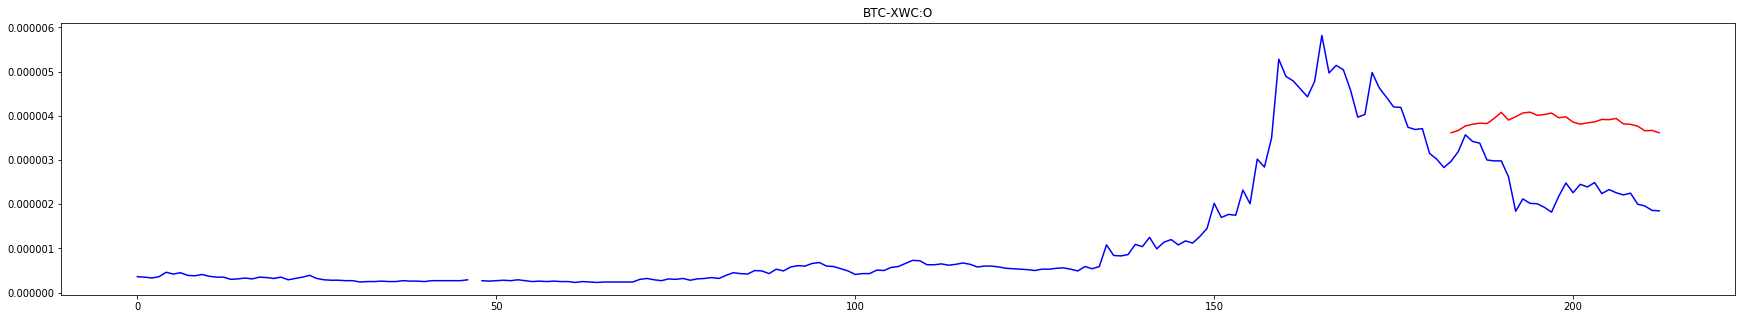

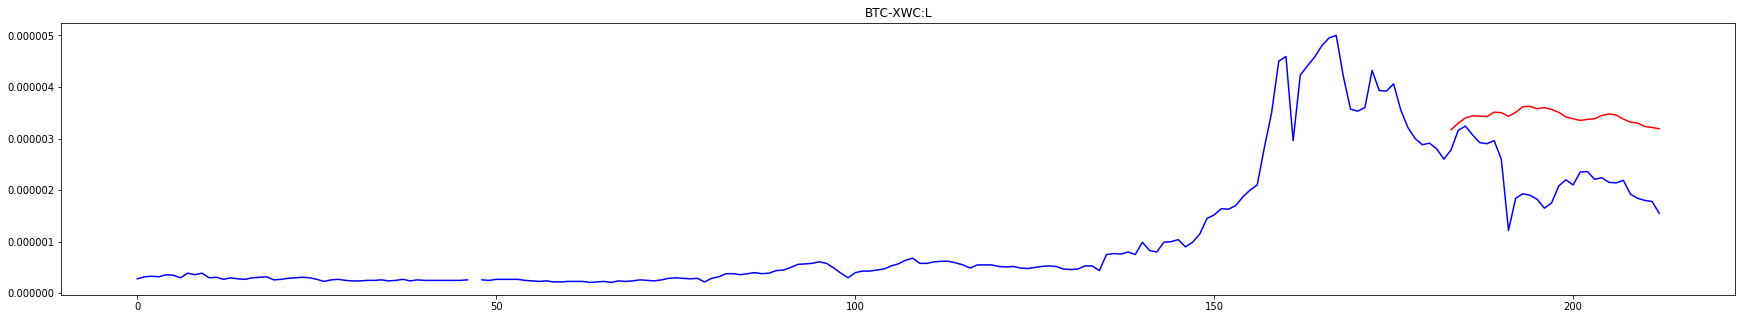

In [10]:
trmf_model = TRMF(lags = [1, 7, 14, 30])
pred_vals = utilities.fit_predict_trmf(trmf_model, data[:, :-30], 30)
for index_to_check in range(0, 40, 3):
    draw_plot(data[index_to_check], index_to_check, pred_data=pred_vals[index_to_check])